<a href="https://colab.research.google.com/github/legion911/Handwritten_Character_Recognition/blob/main/2_Handwritten_Character_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daneshs","key":"8464f287b969a30a3ab1939cde21a2d2"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets list

ref                                                        title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023                 47KB  2023-08-26 11:04:57          17105        539  1.0              
joebeachcapital/students-performance                       Students Performance                              2KB  2023-08-31 00:50:11           6088        150  1.0              
mexwell/motorbike-marketplace                              🏍️ Motorbike Marketplace                          2MB  2023-09-18 05:51:56            768         22  1.0              
iamsouravbanerjee/airline-dataset                          Airline Dataset                               

In [ ]:
! kaggle datasets download -d nibinv23/iam-handwriting-word-database


 98% 1.08G/1.10G [00:09<00:00, 144MB/s]
100% 1.10G/1.10G [00:09<00:00, 121MB/s]


In [ ]:
! unzip iam-handwriting-word-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: iam_words/words/p06/p06-069/p06-069-03-07.png  
  inflating: iam_words/words/p06/p06-069/p06-069-03-08.png  
  inflating: iam_words/words/p06/p06-069/p06-069-03-09.png  
  inflating: iam_words/words/p06/p06-069/p06-069-03-10.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-00.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-01.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-02.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-03.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-04.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-05.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-06.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-00.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-01.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-02.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-03.png  
  inflating: iam_words/words/p06/p

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.utils import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
images = []
labels = []

RECORDS_COUNT = 30000

In [ ]:
with open('/content/iam_words/words.txt') as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents]
lines[1004]

'a01-020-04-03 ok 176 873 1646 135 97 VB give'

In [ ]:
def process_image(img):

    w, h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    img = img.astype('float32')
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    img = cv2.subtract(255, img)
    img = np.expand_dims(img, axis=2)
    img = img / 255
    return img

In [ ]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# string.ascii_letters + string.digits (Chars & Digits)
# or
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [ ]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status= splits[1]
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')
        filepath = './iam_words/words/{}/{}-{}/{}.png'.format(splits_id[0],
                                                  splits_id[0],
                                                  splits_id[1],
                                                  word_id)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
        try:
            label = encode_to_labels(word)
        except:
            continue
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        if len(word) > max_label_len:
            max_label_len = len(word)
    if index >= RECORDS_COUNT:
        break



In [ ]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [ ]:
train_labels[3101]

[70, 67, 56, 65, 55, 60, 65, 58]

In [ ]:
train_padded_label[3101]

array([70, 67, 56, 65, 55, 60, 65, 58, 78, 78, 78, 78, 78, 78, 78, 78, 78],
      dtype=int32)

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((18074, 17), (2007, 17))

In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [ ]:

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [ ]:
def Model1():
    # input with shape of height=32 and width=128
    inputs = Input(shape=(32,128,1))

    # convolution layer with kernel size (3,3)
    conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
    # poolig layer with kernel size (2,2)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

    conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
    # poolig layer with kernel size (2,1)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.24))(squeezed)
    blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.24))(blstm_1)

    outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

    # model to be used at test time
    act_model = Model(inputs, outputs)

    return act_model,outputs,inputs

In [ ]:
act_model,outputs,inputs=Model1()

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 32, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
batch_size = 5
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/30
3615/3615 [==============================] - ETA: 0s - loss: 13.6392 - accuracy: 0.0134
Epoch 1: val_accuracy improved from -inf to 0.05282, saving model to sgdo-30000r-30e-18074t-2007v.hdf5
3615/3615 [==============================] - 110s 25ms/step - loss: 13.6392 - accuracy: 0.0134 - val_loss: 12.0622 - val_accuracy: 0.0528


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
3614/3615 [============================>.] - ETA: 0s - loss: 9.0566 - accuracy: 0.0966
Epoch 2: val_accuracy improved from 0.05282 to 0.18934, saving model to sgdo-30000r-30e-18074t-2007v.hdf5
3615/3615 [==============================] - 88s 24ms/step - loss: 9.0561 - accuracy: 0.0967 - val_loss: 6.2377 - val_accuracy: 0.1893
Epoch 3/30
3615/3615 [==============================] - ETA: 0s - loss: 5.3195 - accuracy: 0.2249
Epoch 3: val_accuracy improved from 0.18934 to 0.28949, saving model to sgdo-30000r-30e-18074t-2007v.hdf5
3615/3615 [==============================] - 85s 24ms/step - loss: 5.3195 - accuracy: 0.2249 - val_loss: 4.3975 - val_accuracy: 0.2895
Epoch 4/30
3615/3615 [==============================] - ETA: 0s - loss: 3.7436 - accuracy: 0.3118
Epoch 4: val_accuracy did not improve from 0.28949
3615/3615 [==============================] - 86s 24ms/step - loss: 3.7436 - accuracy: 0.3118 - val_loss: 4.2551 - val_accuracy: 0.2790
Epoch 5/30
3613/3615 [================

In [ ]:
model.save(filepath='./model3.h5', overwrite=False, include_optimizer=True)

In [ ]:
! pip install python-Levenshtein==0.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Reason for being yanked: Insecure, upgrade to 0.12.1
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp310-cp310-linux_x86_64.whl size=155429 sha256=05153a6af450dd8d55c476344766bc68449365501776b8bc63b6ccdae6a01108
  Stored in directory: /root/.cache/pip/wheels/64/9d/d4/b0f4b842be0e66baad0fdf1b91dd90b36b4135feefc8dfae55
Successfully built python-Levenshtein


In [ ]:
filepath='/content/sgdo-30000r-30e-18074t-2007v.hdf5'
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0

# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))

63/63 [==============================] - 4s 21ms/step
jaro : 0.9412834904489131


1/1 [==============================] - 0s 46ms/step
original_text =   that
predicted text = that

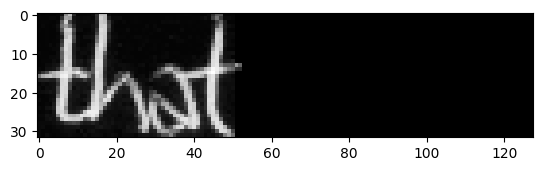



original_text =   want
predicted text = weont

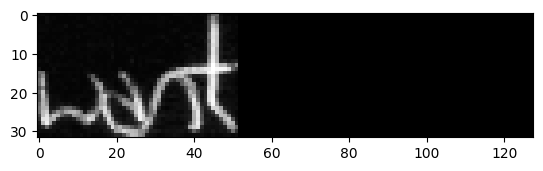



original_text =   in
predicted text = in

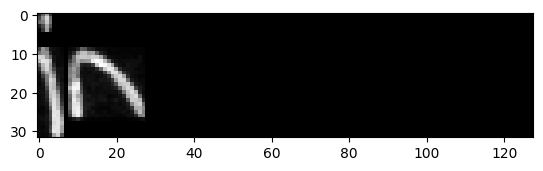



original_text =   ,
predicted text = ,

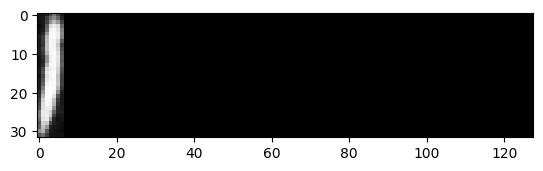

In [ ]:
i=2000
j=2004
prediction = act_model.predict(valid_images[i:j])

decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

for _, x in enumerate(out):

    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    i+=1
    print('\n')


2/2 [==============================] - 1s 502ms/step
original_text =   manufacturing
predicted text = manefactuoring

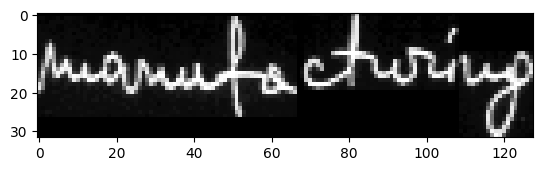



original_text =   another
predicted text = anther

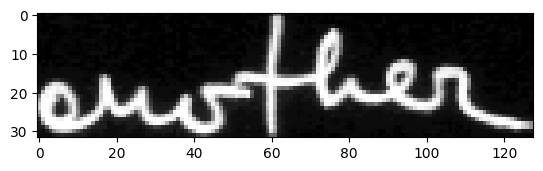



original_text =   to
predicted text = to

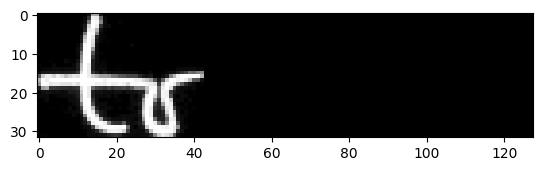



original_text =   he
predicted text = he

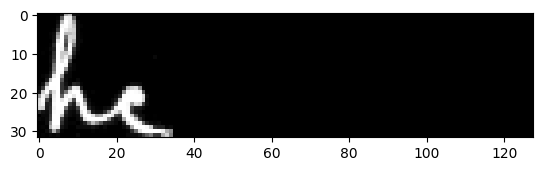



original_text =   less
predicted text = less

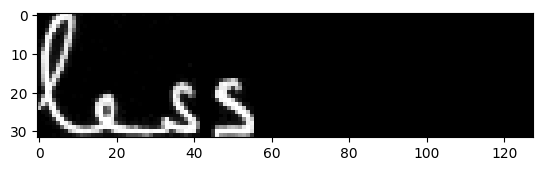



original_text =   ,
predicted text = ,

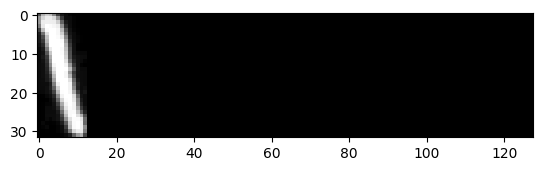



original_text =   eleven
predicted text = eleven

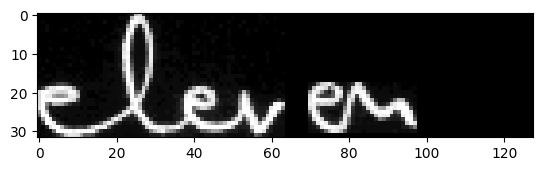



original_text =   Dictionary
predicted text = Dictionary

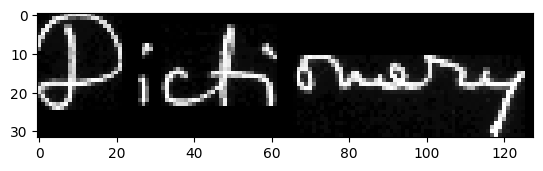



original_text =   Shades
predicted text = shades

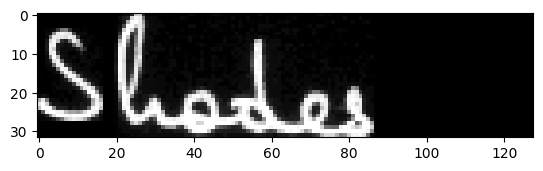



original_text =   the
predicted text = the

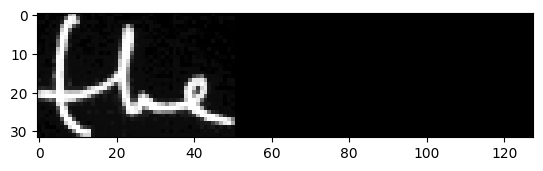



original_text =   have
predicted text = have

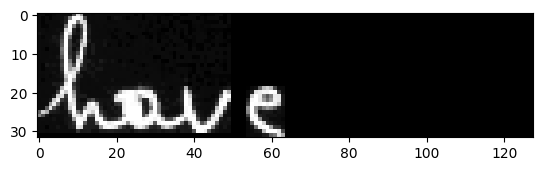



original_text =   with
predicted text = with

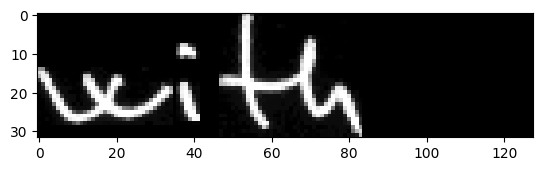



original_text =   real
predicted text = real

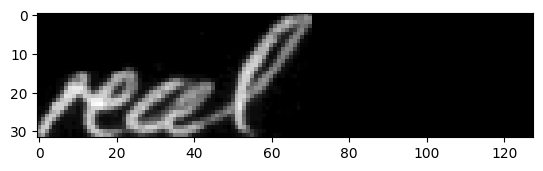



original_text =   a
predicted text = a

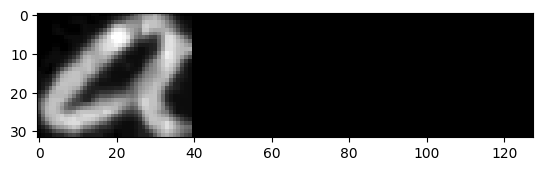



original_text =   a
predicted text = a

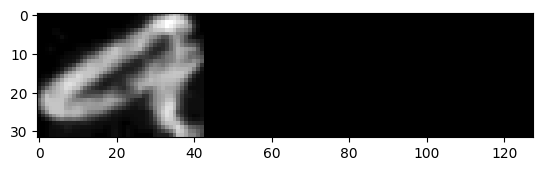



original_text =   and
predicted text = and

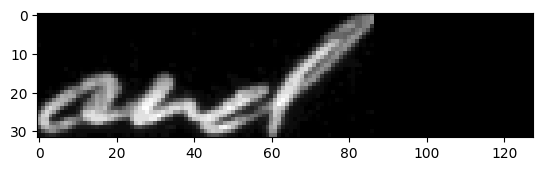



original_text =   statistical
predicted text = statidical

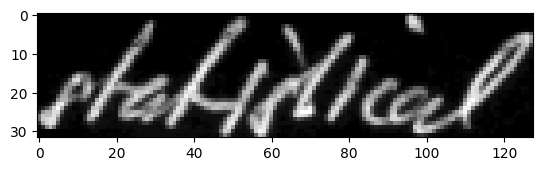



original_text =   rare
predicted text = rare

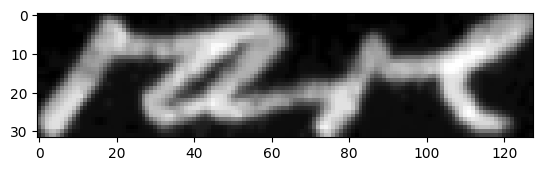



original_text =   the
predicted text = the

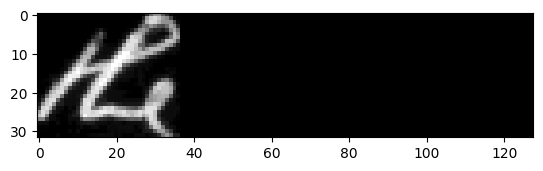



original_text =   continues
predicted text = continuer

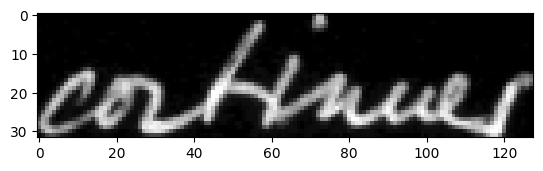



original_text =   mind
predicted text = mind

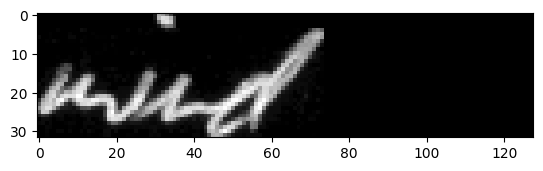



original_text =   an
predicted text = an

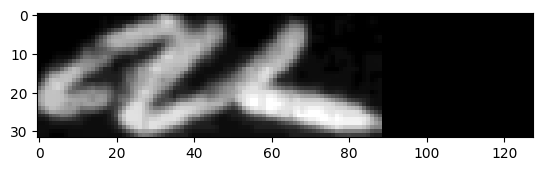



original_text =   that
predicted text = that

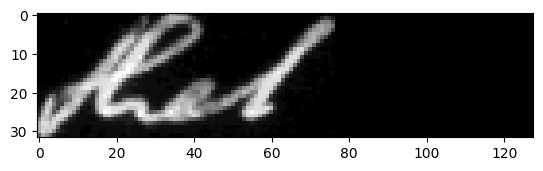



original_text =   death
predicted text = death

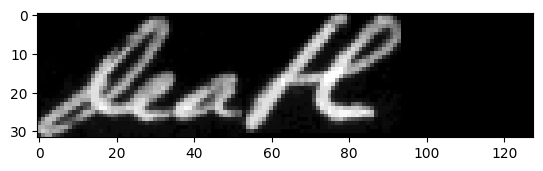



original_text =   fact
predicted text = fect

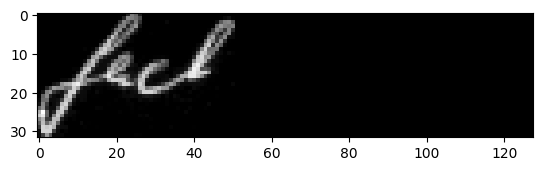



original_text =   not
predicted text = not

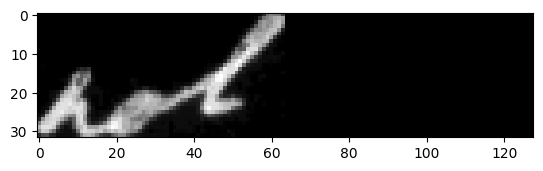



original_text =   who
predicted text = who

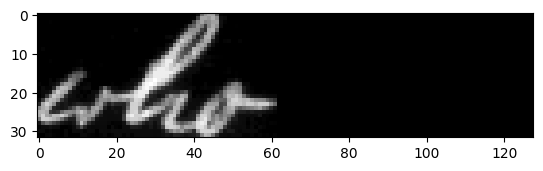



original_text =   I
predicted text = I

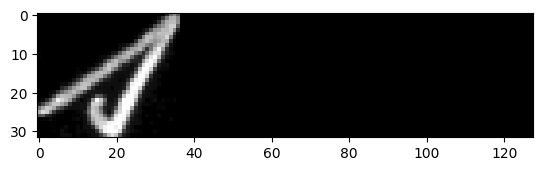



original_text =   .
predicted text = .

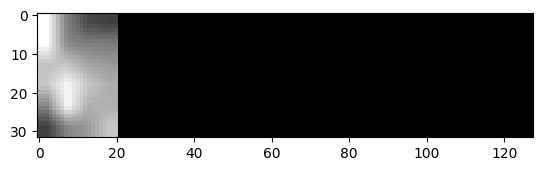



original_text =   other
predicted text = oler

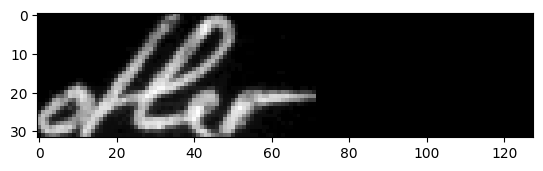



original_text =   certain
predicted text = cestain

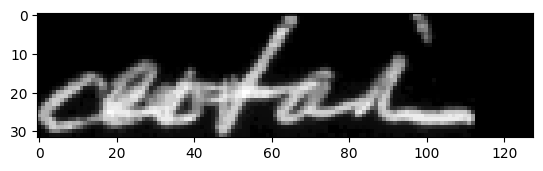



original_text =   small
predicted text = suall

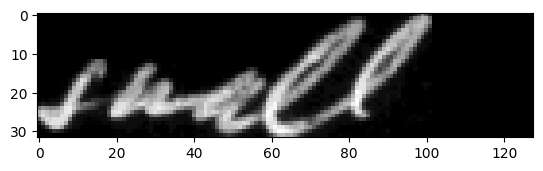



original_text =   to
predicted text = to

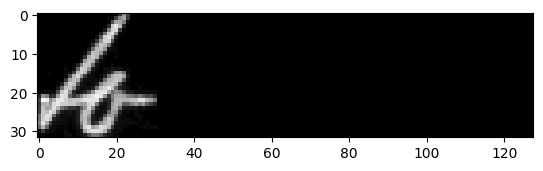



original_text =   apex
predicted text = ape

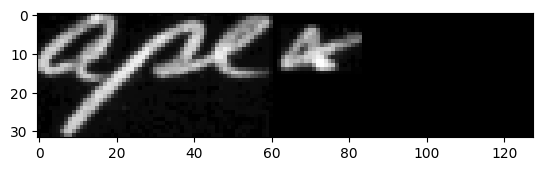



original_text =   knowledge
predicted text = heserledye

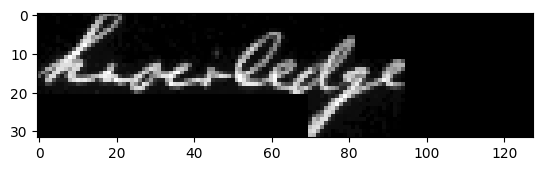



original_text =   led
predicted text = led

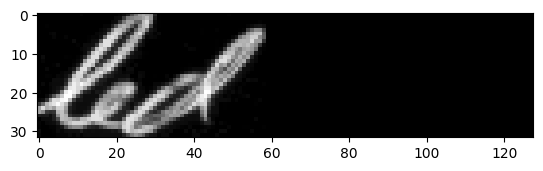



original_text =   with
predicted text = with

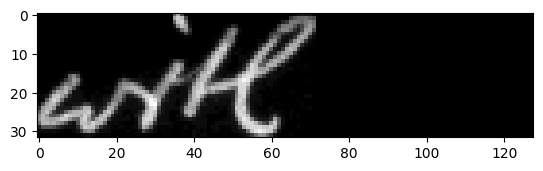



original_text =   used
predicted text = used

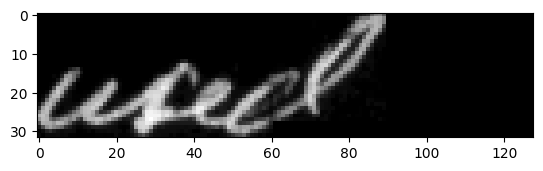



original_text =   about
predicted text = about

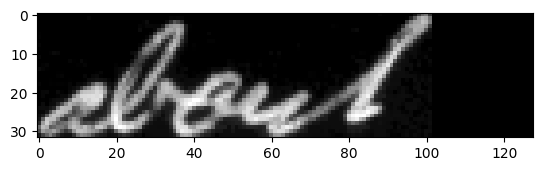



original_text =   and
predicted text = and

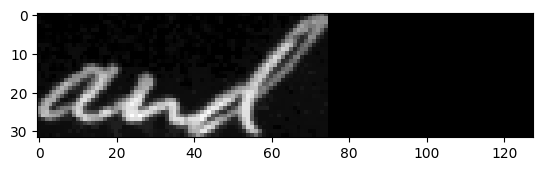



original_text =   red
predicted text = red

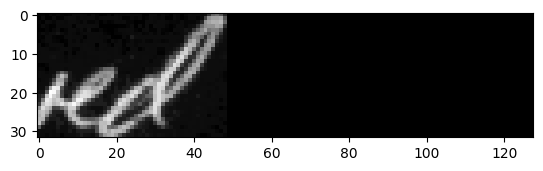



original_text =   of
predicted text = of

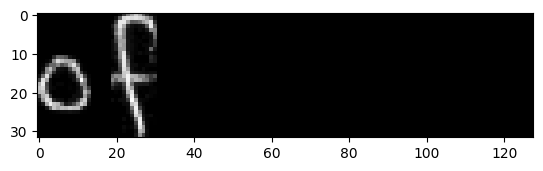



original_text =   into
predicted text = into

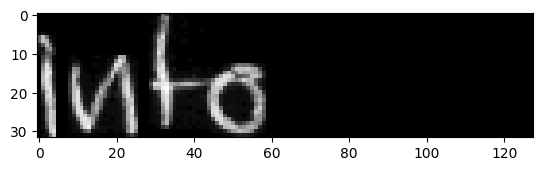



original_text =   they
predicted text = thsy

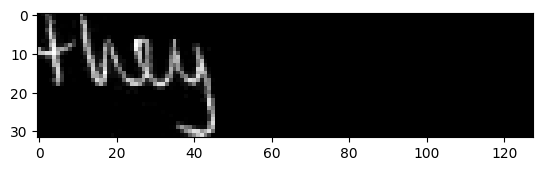



original_text =   they
predicted text = they

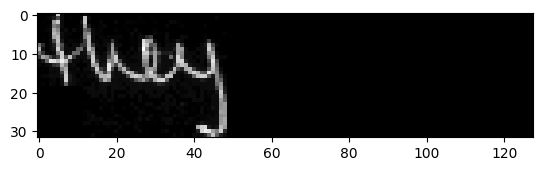



original_text =   in
predicted text = in

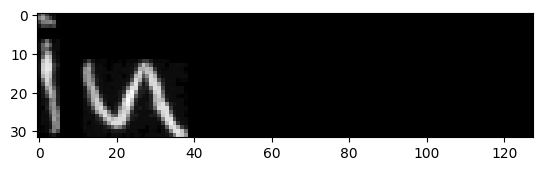



original_text =   which
predicted text = which

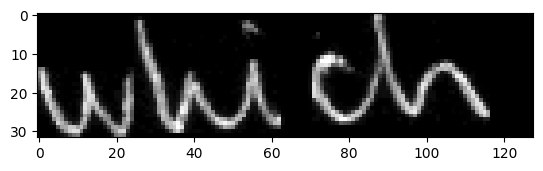



original_text =   :
predicted text = :

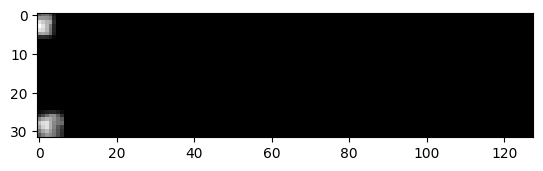



original_text =   death
predicted text = death

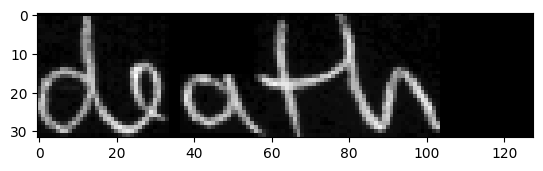



original_text =   we
predicted text = we

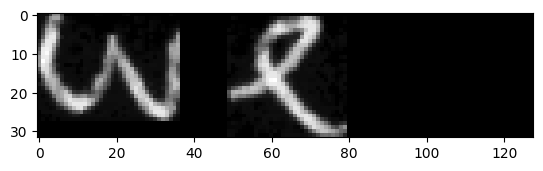

In [ ]:
i=1750
j=1800
prediction = act_model.predict(valid_images[i:j])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results to try and compare predicted and original text
for _, x in enumerate(out):

    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    i+=1
    print('\n')

In [ ]:
def plotgraph(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

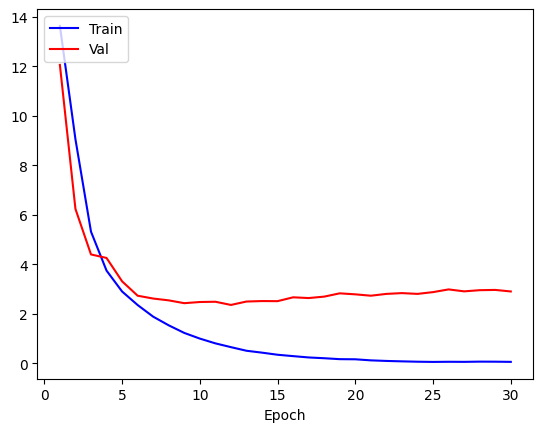

In [ ]:
plotgraph(epochs, loss, val_loss)

In [ ]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [ ]:
print(best_loss)
print(best_acc)
print(best_val_acc)
print(best_val_loss)

0.6480244994163513
0.7503042817115784
0.605381190776825
2.354901075363159


In [ ]:
print(max(acc))



0.9826822876930237
